### Download Repository

In [3]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.10.0+cu111 torchvision==0.11.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [5]:
!pip install openmim
!mim install mmdet

mmdet==2.19.1 existed.


In [6]:
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Cloning into 'mmdetection'...
remote: Enumerating objects: 22371, done.
remote: Total 22371 (delta 0), reused 0 (delta 0), pack-reused 22371
Receiving objects: 100% (22371/22371), 25.47 MiB | 24.01 MiB/s, done.
Resolving deltas: 100% (15659/15659), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Running setup.py develop for mmdet


In [7]:
# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

In [8]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.10.0+cu111 True
2.19.1
11.1
GCC 7.3


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Preprocessing

We need to read annotations of each image and convert them into coco 
format:

In [10]:
import os
import json
import cv2
import random
import time

In [ ]:
#### This is where the conversion process starts from YOLO to COCO format

# Category file, one category per line
yolo_format_classes_path = '/content/drive/MyDrive/classes.txt'
# Write the category according to your own data set. 

#Read the categories file and extract all categories
with open(yolo_format_classes_path,'r') as f1:
    lines1 = f1.readlines()
categories = []
for j,label in enumerate(lines1):
    label = label.strip()
    categories.append({'id':j,'name':label,'supercategory': label})
    #categories.append({'id':j+1,'name':label,'supercategory': label})
    
write_json_context = dict()
write_json_context['info'] = {'description': '', 'url': '', 'version': '', 'year': 2021, 'contributor': '', 'date_created': '2021-02-12 11:00:08.5'}
write_json_context['licenses'] = [{'id': 1, 'name': None, 'url': None}]
write_json_context['categories'] = categories
write_json_context['images'] = []
write_json_context['annotations'] = []

In [ ]:
# Read the YOLO formatted label files (.txt) to extarct bounding box information and store in COCO format

#Read the label files (.txt) to extarct bounding box information and store in COCO format
directory_labels = os.fsencode("/content/drive/MyDrive/yolov5_train_dataset/label_0")
directory_images = os.fsencode("/content/drive/MyDrive/yolov5_train_dataset/image_0")

file_number = 1
num_bboxes = 1
for file in os.listdir(directory_images):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg"):
        img_path = (os.path.join(directory_images.decode("utf-8"), filename))
        base=os.path.basename(img_path)
        file_name_without_ext = os.path.splitext(base)[0] # name of the file without the extension
        yolo_annotation_path  = os.path.join(directory_labels.decode("utf-8"), file_name_without_ext+ "." + 'txt')
        img_name = os.path.basename(img_path) # name of the file without the extension
        img_context = {}
        height,width = cv2.imread(img_path).shape[:2]
        img_context['file_name'] = img_name
        img_context['height'] = height
        img_context['width'] = width
        img_context['date_captured'] = '2021-02-12 11:00:08.5'
        img_context['id'] = file_number # image id
        img_context['license'] = 1
        img_context['coco_url'] =''
        img_context['flickr_url'] = ''
        write_json_context['images'].append(img_context)
        
        with open(yolo_annotation_path,'r') as f2:
            lines2 = f2.readlines() 

        for i,line in enumerate(lines2): # for loop runs for number of annotations labelled in an image
            line = line.split(' ')
            bbox_dict = {}
            class_id, x_yolo,y_yolo,width_yolo,height_yolo= line[0:]
            x_yolo,y_yolo,width_yolo,height_yolo,class_id= float(x_yolo),float(y_yolo),float(width_yolo),float(height_yolo),int(class_id)
            bbox_dict['id'] = num_bboxes
            bbox_dict['image_id'] = file_number
            bbox_dict['category_id'] = class_id+1
            bbox_dict['iscrowd'] = 0 # There is an explanation before
            h,w = abs(height_yolo*height),abs(width_yolo*width)
            bbox_dict['area']  = h * w
            x_coco = round(x_yolo*width -(w/2))
            y_coco = round(y_yolo*height -(h/2))
            if x_coco <0: #check if x_coco extends out of the image boundaries
                x_coco = 1
            if y_coco <0: #check if y_coco extends out of the image boundaries
                y_coco = 1
            bbox_dict['bbox'] = [x_coco,y_coco,w,h]
            bbox_dict['segmentation'] = [[x_coco,y_coco,x_coco+w,y_coco, x_coco+w, y_coco+h, x_coco, y_coco+h]]
            write_json_context['annotations'].append(bbox_dict)
            num_bboxes+=1
        
        file_number = file_number+1
        continue
    else:
        continue
        
 # Finally done, save!
coco_format_save_path = '/content/drive/MyDrive/ssd_train_dataset/image_0.json'
with open(coco_format_save_path,'w') as fw:
    json.dump(write_json_context,fw) 
    

### Modify the config

We need to modify the config for the training. To accelerate the process, we finetune a detector using a pre-trained detector. Save the config below to a .py file before training (I saved it into my google drive).

In [ ]:
# The new config inherits a base config to highlight the necessary modification
_base_ = '/content/mmdetection/configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_1x_coco.py'

# We also need to change the num_classes in head to match the dataset's annotation
model = dict(
    roi_head=dict(
        bbox_head=dict(num_classes=5),
        mask_head=dict(num_classes=5)))

# Modify dataset related settings
dataset_type = 'COCODataset'
classes = ('unknown','vehicle','pedestrians','signs','cyclists',)
data = dict(
    train=dict(
        img_prefix = 'PATH TO IMAGES',
        classes=classes,
        ann_file = 'PATH TO JASON FILE'),
    val=dict(
        img_prefix='PATH TO IMAGES',
        classes=classes,
        ann_file = 'PATH TO JASON FILE'),
    test=dict(
        img_prefix='PATH TO IMAGES',
        classes=classes,
        ann_file='PATH TO JASON FILE'))

# We can use the pre-trained Mask RCNN model to obtain higher performance
load_from = '/content/mmdetection/checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

In [ ]:
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
      -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

--2021-12-20 02:44:09--  https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.18
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/octet-stream]
Saving to: ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

checkpoints/mask_rc 100%[===================>] 169.63M  8.54MB/s    in 19s     

2021-12-20 02:44:29 (8.72 MB/s) - ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]



### Train

In [ ]:
!python tools/train.py /content/drive/MyDrive/mask_rcnn/config.py

2021-12-19 22:35:12,499 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.12 (default, Sep 10 2021, 00:21:48) [GCC 7.5.0]
CUDA available: True
GPU 0: Tesla K80
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.1.TC455_06.29190527_0
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.10.0+cu111
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=

After training, save the result(I saved it into google drive).

In [ ]:
!python tools/test.py /content/drive/MyDrive/mask_rcnn/config.py /content/mmdetection/work_dirs/config/latest.pth --out /content/drive/MyDrive/mask_rcnn/test.pkl --eval bbox segm

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
load checkpoint from local path: /content/mmdetection/work_dirs/config/latest.pth
[>>] 199/199, 1.5 task/s, elapsed: 134s, ETA:     0s
writing results to /content/drive/MyDrive/mask_rcnn/test.pkl

Evaluating bbox...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.30s).
Accumulating evaluation results...
DONE (t=0.20s).

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.518
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.697
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.610
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.683
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.815
 Av

### Plot the mAP&loss Curve and Save them as .jpg

In [ ]:
!pip install seaborn
!python /content/mmdetection/tools/analysis_tools/analyze_logs.py plot_curve /content/mmdetection/work_dirs/config/20211219_223512.log.json --keys bbox_mAP --legend mAP --out /content/drive/MyDrive/mask_rcnn/mAP_maskrcnn.jpg

plot curve of /content/mmdetection/work_dirs/config/20211219_223512.log.json, metric is bbox_mAP
save curve to: /content/drive/MyDrive/mask_rcnn/mAP_maskrcnn.jpg


In [ ]:
!python /content/mmdetection/tools/analysis_tools/analyze_logs.py plot_curve /content/mmdetection/work_dirs/config/20211219_223512.log.json --keys loss_cls --legend mAP --out /content/drive/MyDrive/mask_rcnn/loss_maskrcnn.jpg

plot curve of /content/mmdetection/work_dirs/config/20211219_223512.log.json, metric is loss_cls
save curve to: /content/drive/MyDrive/mask_rcnn/loss_maskrcnn.jpg


### Run the Best Result

In [11]:
import mmcv
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
img = mmcv.imread('/content/drive/MyDrive/000000000000198.jpg')

#model = init_detector('/content/mmdetection/configs/aaa/maskrcnn.py')
# Choose to use a config and initialize the detector
config = '/content/drive/MyDrive/mask_rcnn/config.py'
# Setup a checkpoint file to load
checkpoint = '/content/drive/MyDrive/mask_rcnn/latest.pth'
# initialize the detector
model = init_detector(config, checkpoint, device='cuda:0')
result = inference_detector(model, img)

load checkpoint from local path: /content/drive/MyDrive/mask_rcnn/latest.pth


/content/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


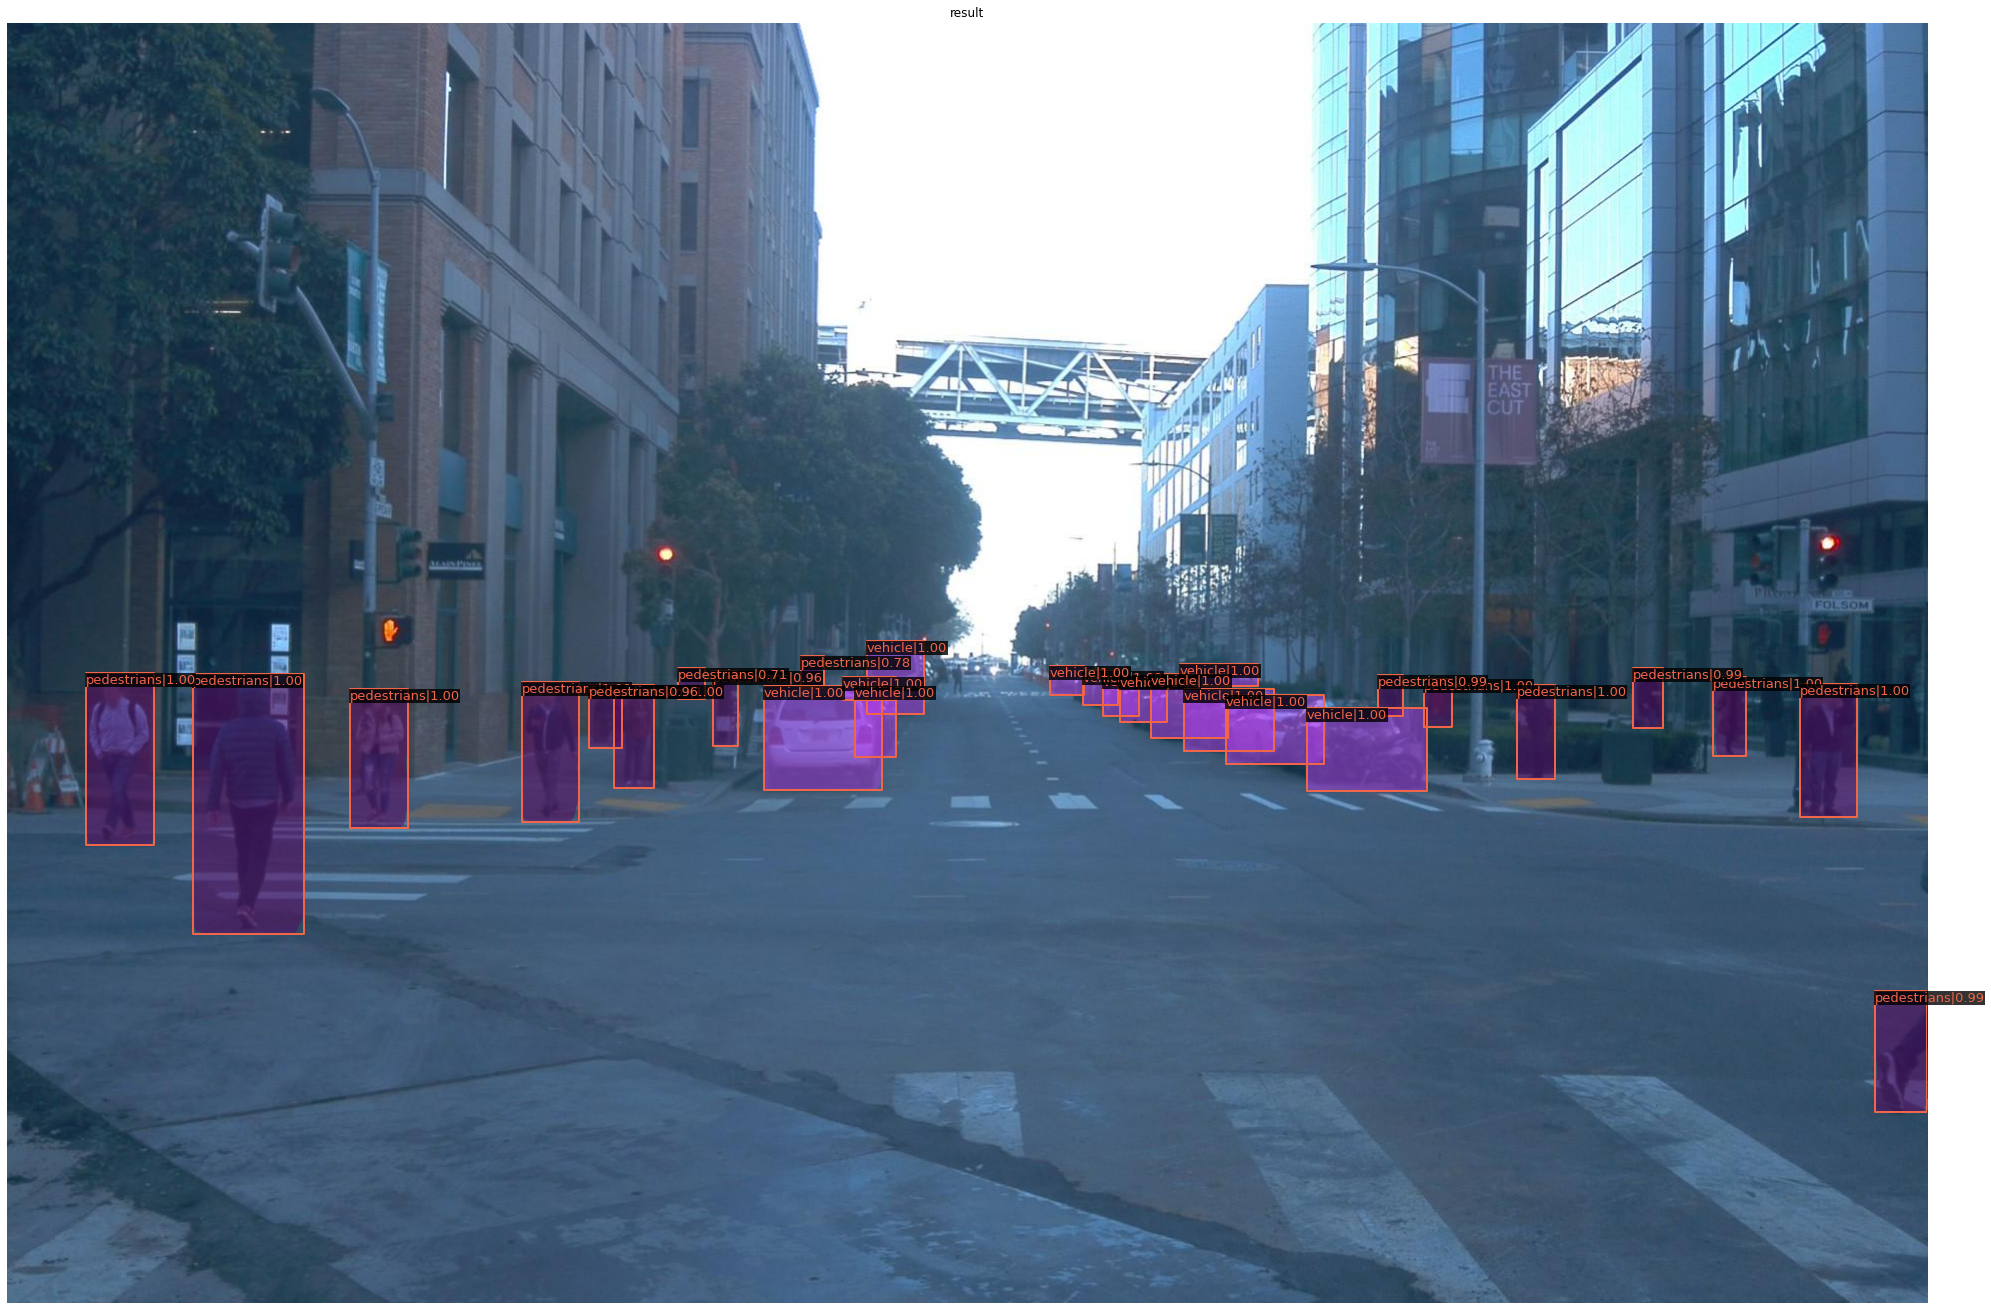

In [37]:
show_result_pyplot(model, img, result, score_thr=0.4)

### Demo

In [47]:
def processing_time(start_time, end_time):
    processing_time = end_time - start_time
    processing_min = int(processing_time / 60)
    processing_sec = int(processing_time - (processing_min * 60))
    return processing_min, processing_sec

In [48]:
# read video
video = mmcv.VideoReader('/content/drive/MyDrive/DRIVING IN KABUL CITY.mp4')

In [49]:
# split a video into frames and save to a folder
video.cvt2frames('/content/drive/MyDrive/video_frames')

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4973/4973, 49.6 task/s, elapsed: 100s, ETA:     0s


In [ ]:
import time
start_time = time.time()
for name in os.listdir('/content/drive/MyDrive/video_frames'):
  img = mmcv.imread('/content/drive/MyDrive/video_frames/'+name)
  result = inference_detector(model, img)
  model.show_result(img, result, out_file='/content/drive/MyDrive/video_frames_boxes/'+name, score_thr=0.6)
end_time = time.time()
mins, seconds = processing_time(start_time, end_time)

In [12]:
# generate video from frames
mmcv.frames2video('/content/drive/MyDrive/video_frames_boxes', '/content/drive/MyDrive/mask_rcnn_demo.mp4')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4554/4554, 54.4 task/s, elapsed: 84s, ETA:     0s
